In [1]:
# %matplotlib notebook
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt, calendar
import os
import seaborn as sns; sns.set(style="ticks", color_codes=True)

# For a bit more data exploration
from sklearn.tree import DecisionTreeRegressor # Import Decision Tree Regressor
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

# import seaborn as sns

# Introduction

The aim of this notebook is to generate data matrices including potential features of use in predicting lake chemistry and ecology in Lake Vansjø. Data is read in for the River Hobøl and Lake Vansjø in the Morsa vannområde. Data includes meteorological data, NVE discharge data, river chemistry data and lake chemistry and ecology data for the period ca. 1980-2017/8. Data is cleaned and aligned, and then seasonal averages or sums are calculated and associated derived features (e.g. lags, winter sums).

Exploratory data analysis is then undertaken, including exploration of correlation coefficients and some graphs. Data matrices for each of the four target variables (lake TP concentration, chl-a concentration, biovolume of cyanobacteria and colour) are written to csv for use elsewhere.

This notebook builds on notebook 01_Make_data_matrix.ipynb, where the aim was monthly rather than seasonal aggregation of the data. Notebook 01 contains some more exploration of the daily data and explanations for some of the data cleaning choices made.

Created by Leah JB. Part of the ERA4CS WATExR project.

# Paths to files and folders

In [2]:
# User input
# Which Vansjø basin? Van1 (Storefjorden), Van2 (Vanemfjorden)
basin = 'Van2'

# Include TP flux estimates in the data matrix?
inc_fluxes = 0 # 0 or 1

# Include features from Van1 in Van2's features? Only relevant if basin is Van2
inc_Van1 = 0

# FILE PATHS to input data

# Met (T, pptn)
met_fpath = r'../../data/Obs_Metno_1km_gridded_Morsa_v2.csv'
wind_fpath = r'../../data/Obs_Rygge_MeanWindSpeed.csv' # Mean daily wind speed (m/s), Rygge airport
PET_fpath = r'../../data/Morsa_ThornthwaitePET.csv' #N.B. calculated using met station temp rather than gridded. But the two are v. comparable (not so pptn)

# Discharge
Q_fpath = r'../../data/3-22-0_D6pm_Hogfoss_Scaled_to_Kure.csv'

# Catchment water quality (at Kure)
catchwq_fpath = r'../../data/003-59191_chem_obs.csv'

# Lake water quality
fname_dict = {'Van1':'Van1_Storefjorden', 'Van2':'Van2_Vanemfjorden'}
lakewq_fpath = r'../../data/%s_chem_obs.csv'%fname_dict[basin]

# Alternative lake colour data (from Storefjorden, 20m depth, MOVAR data)
movar_color_fpath = r'../../data/LakeColour_MOVAR.csv'

# Lake ecology (PTI, biovolume, cyanomax, cyano biovolume)
ecol_fpath = r'../../data/%s_PTI_Cyano.xlsx'%basin

# Output folders
out_file = r'../../data/DataMatrices'
graph_outfolder = r'../../Figures/Scatterplots'

# Read in daily data

In [3]:
# READ IN
met_df = pd.read_csv(met_fpath, index_col=0, parse_dates=True, dayfirst=True)
pet_df = pd.read_csv(PET_fpath, index_col=0, parse_dates=True, dayfirst=True)
wind_df = pd.read_csv(wind_fpath, index_col=0, parse_dates=True, dayfirst=True)

Q_df = pd.read_csv(Q_fpath, index_col=0, parse_dates=True, dayfirst=True)

catchwq_df = pd.read_csv(catchwq_fpath, index_col=0, parse_dates=True, dayfirst=True)

lakewq_df = pd.read_csv(lakewq_fpath, index_col=0, parse_dates=True, dayfirst=True)
color_df = pd.read_csv(movar_color_fpath, index_col=0, parse_dates=True, dayfirst=True)

# If looking at Van2 (Vanemfjorden), also read in lake data from Storefjorden
if basin =='Van2' and inc_Van1==1:
    lakewq_df_van1 = pd.read_csv(r'../../data/%s_chem_obs.csv'%fname_dict['Van1'], index_col=0, parse_dates=True, dayfirst=True)

# Read in ecol data from excel sheet one sheet at a time, then merge
PTI_df = pd.read_excel(ecol_fpath, sheet_name=0, index_col=3, parse_dates=True)
biovol_df = pd.read_excel(ecol_fpath, sheet_name=1, index_col=3, parse_dates=True)
cyanoBiovol_df = pd.read_excel(ecol_fpath, sheet_name=2, index_col=0, parse_dates=True)
ecol_df = pd.concat([PTI_df['PTI'], biovol_df['Biovolume_mm3_per_l'], cyanoBiovol_df['Cyano_biovol_mm3_per_l']], axis=1)

# Data cleaning and reorganising

For plots of data see notebook 01 (Make_data_matrix_monthly). That code is repeated here.

## Extract cols of interest from met and Q dfs

In [4]:
# MET DATA

# For the met data, just pick the columns of interest and rename them
met_df = met_df[['RR_catch','TG_catch']] # For now, pick rainfall and temp averaged over whole catchment, not just the lake
met_df.columns = ['Pptn','Temp']
met_df.index.name = 'Date'
met_df.index = met_df.index.normalize() # Drop time info from metdf index

# Add mean daily wind speed (m/s)
met_df['Wind_speed'] = wind_df.iloc[:,0]

# Also add PET (mm/day)
met_df['PET'] = pet_df['PET']

# Q DATA
Q_df = Q_df['Q_18H_average_m3s_scaled']
Q_df.rename('Q', inplace=True)

# Lake colour data (merge MOVAR and NIVA data). Before Jan 1999: NIVA data, Jan 1999- end 2012: Movar data, from Jan 2013: NIVA data
lakewq_df = pd.merge(lakewq_df, color_df, left_index=True, right_index=True, how='outer')

## Process lake colour data

In [5]:
# Before Jan 1999: NIVA data, Jan 1999- end 2012: Movar data, from Jan 2013: NIVA data
s0 = lakewq_df.loc[:'1998-12-31','colour']

id1 = lakewq_df['Colour'].first_valid_index()
s1 = lakewq_df['Colour'].loc[id1:]
s1.name = 'colour'

lastidx = lakewq_df.loc['2013-01-01':,'colour'].last_valid_index()
s2 = lakewq_df.loc['2013-01-01':lastidx,'colour']

colour = pd.concat([s0, s1,s2], axis=0).dropna()

# Drop original MOVAR and NIVA colour series, and replace with the patched series
lakewq_df = lakewq_df.drop(['colour','Colour'], axis=1)
lakewq_df = lakewq_df.merge(colour.to_frame(), left_index=True, right_index=True, how='outer')

# Drop some dodgy-looking values
lakewq_df.loc[:'1982-08-01','colour'] = np.NaN
lakewq_df[lakewq_df[['SS','SS_min']]>25.] = np.NaN
met_df.loc[met_df['Pptn']<0.,'Pptn'] = 0.

if basin == 'Van2' and inc_Van1==1:
    lakewq_df_van1.loc[:'1982-08-01','colour'] = np.NaN

## Combine data into one df, drop unwanted cols and rows

['Pptn' 'Temp' 'Wind_speed' 'PET' 'Q' 'TP_catch' 'chl-a_lake' 'TP_lake'
 'colour_lake' 'PTI' 'Biovolume' 'CyanoBiovol']


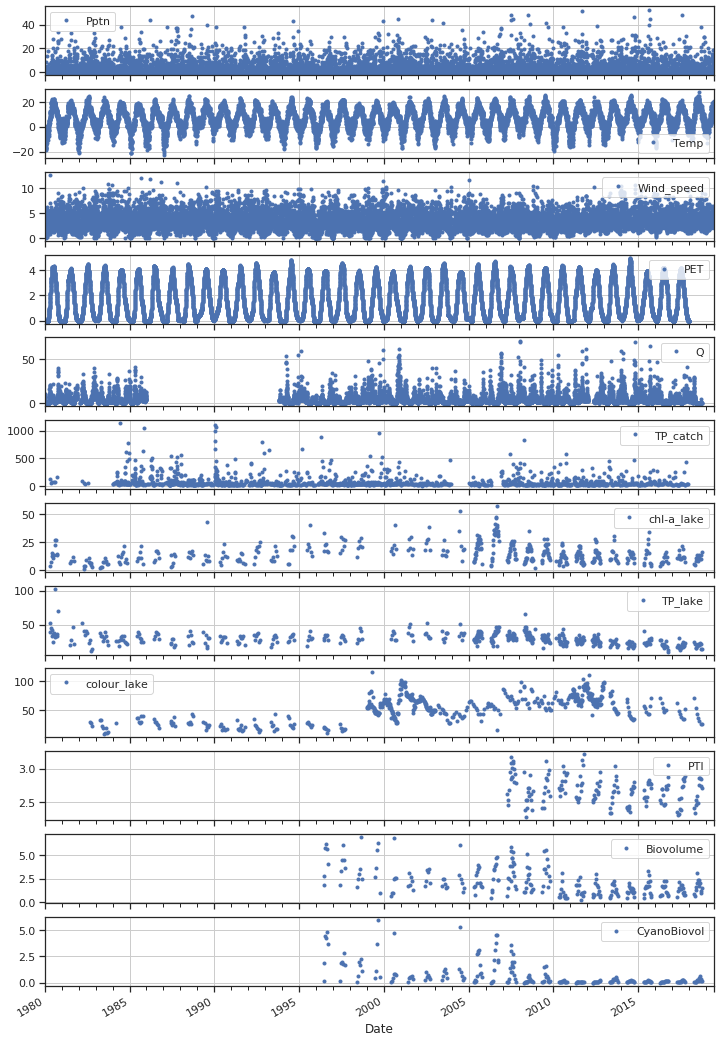

In [6]:
# Add suffixes to lake and water quality columns
catchwq_df = catchwq_df.add_suffix('_catch')
lakewq_df = lakewq_df.add_suffix('_lake')

if basin == 'Van2' and inc_Van1==1:
    lakewq_df_van1 = lakewq_df_van1.add_suffix('_van1')

# REINDEX & JOIN ALL DATASETS INTO ONE DATAFRAME

if basin == 'Van2' and inc_Van1==1:
    df_list = [met_df, Q_df, catchwq_df, lakewq_df, ecol_df, lakewq_df_van1]
else:
    df_list = [met_df, Q_df, catchwq_df, lakewq_df, ecol_df]

for i, df in enumerate(df_list):
    df = df.reindex(index=met_df.index)
    if i<1:
        daily_df = df
    else:
        daily_df = daily_df.join(df)

# Remove data pre-1980
daily_df = daily_df.loc['1980-01-01':,:]

# Drop some cols and rename others
if basin == 'Van2' and inc_Van1==1:
    cols_to_drop = ['SS_min_catch', 'SS_catch','TDP_catch','SRP_catch',
                    'TOC_lake','TDP_lake','SS_lake','SS_min_lake',
                    'TOC_van1', 'TDP_van1', 'SS_min_van1', 'SS_van1',]
else:
    cols_to_drop = ['SS_min_catch', 'SS_catch','TDP_catch','SRP_catch',
                    'TOC_lake','TDP_lake','SS_lake','SS_min_lake']
    
var_rename_dict = {'Biovolume_mm3_per_l':'Biovolume','Cyano_biovol_mm3_per_l':'CyanoBiovol'}

daily_df.drop(cols_to_drop, axis=1, inplace=True)
daily_df.rename(var_rename_dict, axis=1, inplace=True)

# Check output
print(daily_df.columns.values)
daily_fig = daily_df.loc['1980-01-01':,:].plot(subplots=True, style='o', ms=3, figsize=(12,20), grid=True);

# plt.savefig(os.path.join(graph_outfolder,'daily_data_tseries.png'))


## Add precipitation-related features

                Pptn  Rain_day
Date                          
1980-01-01  0.000000         0
1980-01-02  0.000000         0
1980-01-03  0.000000         0
1980-01-04  2.669136         1
1980-01-05  2.806878         1
8.499137083600006
                Pptn  Pptn_intense
Date                              
1980-01-01  0.000000             0
1980-01-02  0.000000             0
1980-01-03  0.000000             0
1980-01-04  2.669136             0
1980-01-05  2.806878             0


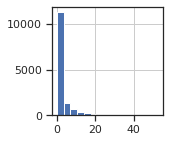

In [7]:
# Add derived variables from daily data.
# Don't bother with residence time or fluxes as didn't seem important in monthly analysis, and for fluxes lots of missing vaules

# Precipitation features:
# (1) rain day (boolean of whether it rained that day or not). There are various definitions and things we could use,
# (e.g., from Australian Met service):
# Wet days    Annual count of days with daily precipitation ≥ 1 mm
# Heavy precipitation days    Annual count of days with daily precipitation ≥ 10 mm
# Very heavy precipitation days    Annual count of days with daily precipitation ≥ 30 mm

# Decide to go with 'Wet day' definition, to filter out small errors in values under 1mm (& which might be dew)

def rain_day(pptn):
    if pptn>1: return 1
    else: return 0
daily_df['Rain_day'] = daily_df['Pptn'].map(rain_day)
print (daily_df[['Pptn','Rain_day']].head())

# (2) pptn intensity: Boolean saying whether precipitation is above a certain threshold
# First, take a look at the distribution of rainfall to decide on the threshold
daily_df['Pptn'].hist(bins=15, figsize=(2,2))
print (daily_df['Pptn'].quantile(q=0.90))

# Decide to go again with AU definition of 'Heavy precipitation days'
def rain_intense(pptn):
    if pptn>10.0: return 1
    else: return 0
daily_df['Pptn_intense'] = daily_df['Pptn'].map(rain_intense)
print (daily_df[['Pptn','Pptn_intense']].head())

## Add wind speed-related features

Nothing wind-related really came out as important in the monthly analysis. So here, cut down on the number of wind-related features to include. Also just add in mean seasonal wind speed.

Median daily wind speed is 3.3 m/s, and the distribution is somewhat right skewed. The main thing that is likely to be important for cyanobacteria is a stable upper water column, so that turbulence doesn't cause cells to sink. The duration of the stable upper water column could also be important, so features could be e.g. x days below whatever wind speed threshold is required for a stable upper water column, AND no (potentially short-lived) periods where the water column is mixed due to high winds.

Q0.2: 2.0 m/s
Q0.4: 2.9 m/s


Q0.6: 3.8 m/s
Q0.8: 4.8 m/s
            Wind_speed  Wind_under_Q0.2  Wind_over_Q0.6
Date                                                   
1980-01-01         2.9            False           False
1980-01-02         3.1            False           False
1980-01-03         1.5             True           False
1980-01-04         1.7             True           False
1980-01-05         1.5             True           False


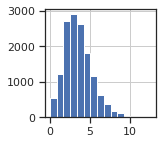

In [8]:
# Wind features: Boolean saying whether wind speed was above or below a certain threshold

# Distribution of wind speed
daily_df['Wind_speed'].hist(bins=15, figsize=(2,2))

# Define 'calm day' features
calm_quantiles = [0.2, 0.4] 
for quantile in calm_quantiles:
    upper_threshold = daily_df['Wind_speed'].quantile(quantile)
    print('Q%s: %s m/s' %(quantile, upper_threshold))
    daily_df['Wind_under_Q%s' %quantile] = daily_df['Wind_speed'] < upper_threshold

print('\n')
    
# Define 'windy day' features
windy_quantiles = [0.6, 0.8]
for quantile in windy_quantiles:
    lower_threshold = daily_df['Wind_speed'].quantile(quantile)
    print('Q%s: %s m/s' %(quantile, lower_threshold))
    daily_df['Wind_over_Q%s' %quantile] = daily_df['Wind_speed'] > lower_threshold
    
print (daily_df[['Wind_speed','Wind_under_Q0.2','Wind_over_Q0.6']].head())

## Add temperature-related features

Later in the analysis I was finding that PET was coming out as a significant feature relating to biol. E.g. winter PET correlating with summer cyanobacterial biovolume. I think this could be more about ice thickness and duration, which I can't find long term records for. Instead, lets calculate winter freezing days (days where T<0), and assume the more subzero days the thicker the ice and the longer the ice duration.

In [9]:
daily_df['Temp_subzero'] = daily_df['Temp']<0.
daily_df[['Temp','Temp_subzero']].head()

,Temp,Temp_subzero
Date,,
1980-01-01,-4.758278,True
1980-01-02,-8.821736,True
1980-01-03,-15.280719,True
1980-01-04,-12.965066,True
1980-01-05,-5.304253,True


# Output daily data matrix

In [10]:
# Optionally output to csv
daily_df.to_csv(os.path.join(out_file,'Vansjø_daily_data_%s.csv' %basin), index_label='Date')

# Resample to seasonal

In [11]:
# Set the aggregation method for different variables

vars_to_sum = ['Pptn','Rain_day','Pptn_intense', 'PET',
              'Q', 'Temp_subzero']

# Add wind cols to vars to sum
wind_cols = []
for q in calm_quantiles:
    wind_cols.append('Wind_under_Q%s' %q)
for q in windy_quantiles:
    wind_cols.append('Wind_over_Q%s' %q)
vars_to_sum += wind_cols
    
vars_to_average = ['TP_catch',
                 'PTI',
                 'Temp',
#                  'Q',
                 'Biovolume',
                 'rel_res_time',
                 'colour_lake',
                 'TP_lake',
                 'chl-a_lake',
                  'Wind_speed',
                  ]

vars_to_max = ['CyanoBiovol']

if basin == 'Van2' and inc_Van1==1:
    vars_to_average.extend(['colour_van1','TP_van1','chl-a_van1'])

agg_method_dict = {} # Key: var, returns aggregation method
for var in daily_df.columns:
    if var in vars_to_sum:
        method = np.nansum
    elif var in vars_to_average:
        method = np.nanmean
    elif var in vars_to_max:
        method = np.nanmax
    else:
        method = None
    agg_method_dict[var] = method

# agg_method_dict

In [12]:
# RESAMPLE TO SEASONAL

# Define 4 seasons per year. Lake sampling is from mid-April to mid-October, WFD status May-Sep. Split this into two (early summer and late summer)
# Value is returned next to the last day of the season

def season(x):
    """Input month number, and return the season it corresponds to
    """
    if x in [11,12,1]:
        return 'wint'
    if x in [2,3,4]:
        return 'spr'
    if x in [5,6,7]:
        return 'summ'
    if x in [8,9,10]:
        return 'aut'

# Resample (enter 'Q' for quarterly, and '-month' for month to end in)
# N.B. if you change season function, need to change this too
season_df = daily_df.resample('Q-Jan').agg(agg_method_dict)
season_df['Season'] = season_df.index.month.map(season)

# print (season_df.head(4))

# For Q, need to correct the units (summed up m3/s over days, convert to 10^6 m3 per season)
season_df['Q'] = season_df['Q'] * (86400./10**6)
# Also, summing over seasons gives 0 for Q due to no data. Replace with NaNs
season_df.loc[season_df['Q']==0.0,'Q'] = np.NaN

# Remove frequncy info from index so all plotting works right
season_df.index.freq=None

season_df.tail(4)

,Pptn,Temp,Wind_speed,PET,Q,TP_catch,chl-a_lake,TP_lake,colour_lake,PTI,Biovolume,CyanoBiovol,Rain_day,Pptn_intense,Wind_under_Q0.2,Wind_under_Q0.4,Wind_over_Q0.6,Wind_over_Q0.8,Temp_subzero,Season
Date,,,,,,,,,,,,,,,,,,,,
2018-10-31,217.862547,12.426755,4.264130,0.0,1.978301,NaN,12.0,18.4,27.666667,2.799266,1.500228,0.614429,28,6,6.0,22.0,49.0,32.0,1.0,aut
2019-01-31,214.289157,0.094538,3.245652,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,6,23.0,47.0,27.0,15.0,52.0,wint
2019-04-30,190.227610,4.238222,3.667416,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,9,6.0,27.0,35.0,20.0,13.0,spr
2019-07-31,199.182835,12.881374,3.856667,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,7,0.0,12.0,25.0,16.0,0.0,summ


## Exploratory boxplots

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:355: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds


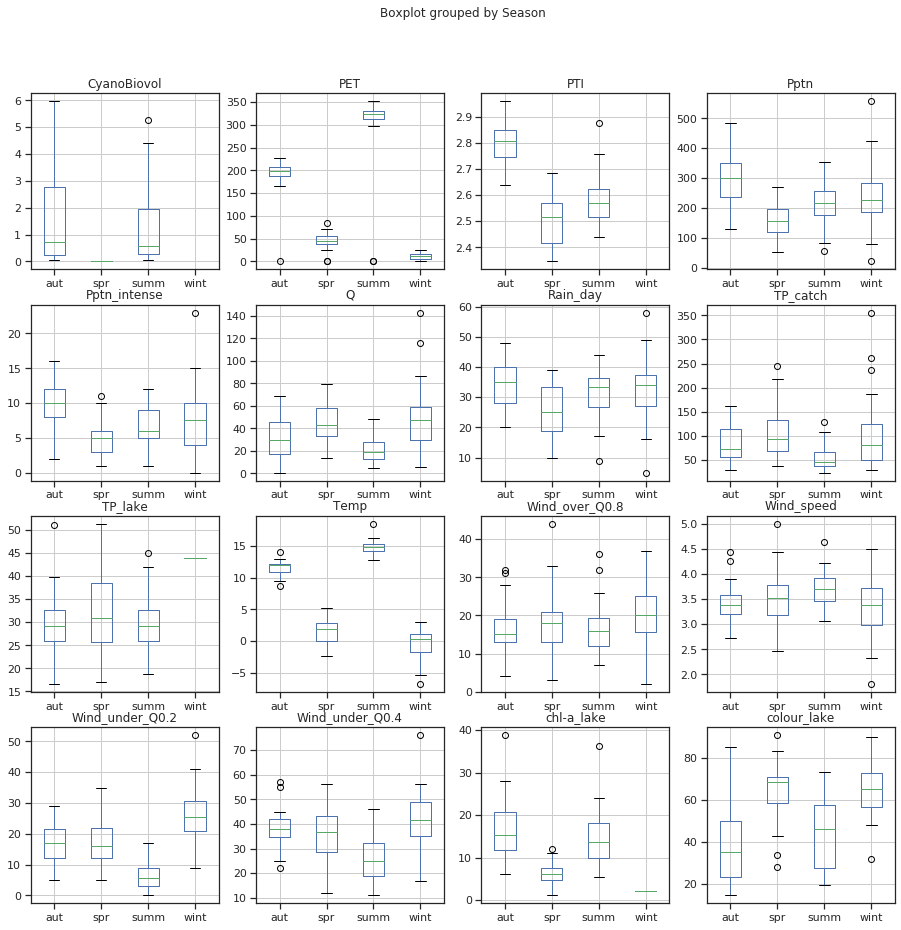

In [13]:
fig, axs = plt.subplots(4,4, sharey=False, figsize=(15,15))
bp = season_df.drop(['Biovolume','Wind_over_Q0.6','Temp_subzero'], axis=1).boxplot(by='Season', ax=axs);
[ax.set_xlabel('') for ax in bp];

# plt.savefig(os.path.join(graph_outfolder, 'Season_boxplots.png'))

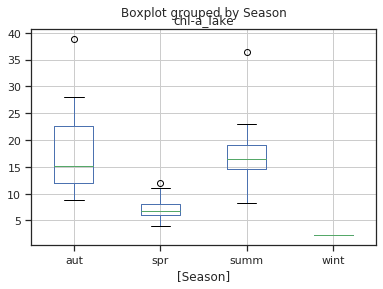

In [14]:
# Zoom in on chl-a, and just for the period where it crosses over with cyanobacteria data

ax = season_df.loc['1997-04-30':,['chl-a_lake','Season']].boxplot(by='Season')

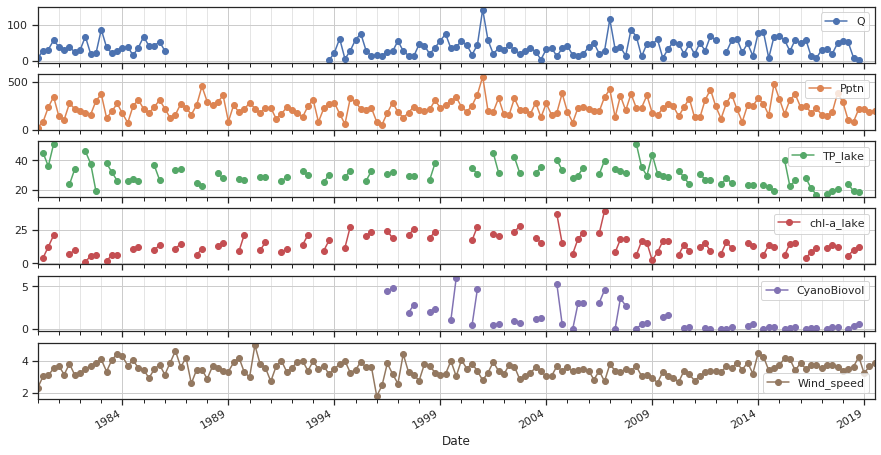

In [15]:
# Time series, to look at winter 2000 flooding event. Can see peak pptn and Q in Nov 2000-Jan 2001.But chl-a was already high before then,
# and cyano if anything decreased for a couple of years after and then went back up again...

ax = season_df.loc[:,['Q','Pptn','TP_lake','chl-a_lake','CyanoBiovol','Wind_speed']].plot(subplots=True, figsize=(15,8), grid=True, marker='o')
ax[0].xaxis.grid(True, which='minor', linestyle='-', linewidth=0.5)
ax[1].xaxis.grid(True, which='minor', linestyle='-', linewidth=0.5)
ax[2].xaxis.grid(True, which='minor', linestyle='-', linewidth=0.5)
ax[3].xaxis.grid(True, which='minor', linestyle='-', linewidth=0.5)
ax[4].xaxis.grid(True, which='minor', linestyle='-', linewidth=0.5)
ax[1].legend(loc='upper right')

## Add lagged variables

In [16]:
# For desired variables, add 1 (and optionally a 2 season) lag

# Only do for variables that we will have data for or may be able to estimate
lag_vars = ['Pptn', 'Temp', 'Wind_speed', 'PET', 'Q', 'chl-a_lake',
           'TP_lake', 'colour_lake', 'CyanoBiovol',
           'Rain_day', 'Pptn_intense',
           'Wind_under_Q0.2', 'Wind_under_Q0.4', 'Wind_over_Q0.6',
           'Wind_over_Q0.8'],

for var in season_df.columns:
    season_df['%s_lag1' %var] = season_df[var].shift(+1)
#     season_df['%s_lag2' %var] = season_df[var].shift(+2)

    
season_df[['Pptn','Pptn_lag1']].head()

,Pptn,Pptn_lag1
Date,,
1980-01-31,22.125336,NaN
1980-04-30,79.892563,22.125336
1980-07-31,234.732986,79.892563
1980-10-31,344.837282,234.732986
1981-01-31,140.053816,344.837282


In [17]:
# For all variables that are summed on aggregating, calculate the sum for the
# previous winter (Oct - March).
# Note: for simplicity, don't include April, as this data would be a combo of ERA5 & seasonal forecast data

# Just pick out vars of interest from daily df
wint_sum_daily_df = daily_df[vars_to_sum]

# Before calculating the winter sum, need to convert units of Q from m3/s to m3/day, so final winter sum is in 10^6 m3
wint_sum_daily_df['Q'] = wint_sum_daily_df['Q'] * (86400./10**6)

# Add new col for whether the daily value is in winter or not (boolean)
def winter(month):
    if month in [10,11,12,1,2,3]:
        return 1
    else:
        return 0
wint_sum_daily_df['winter'] = wint_sum_daily_df.index.month.map(winter, na_action='ignore')

# Add another col for which year the value should be stored against
def wint_sum_yr(index):
    month = index.month
    year = index.year
    if month in [10,11,12]:
        return (year + 1)
    else:
        return (year)
wint_sum_daily_df['year'] = wint_sum_daily_df.index.map(wint_sum_yr, na_action='ignore')

# Group by year and sum if winter==1. Only do sum if there are at least ~90% of values present for the season
wint_sum_df = wint_sum_daily_df.loc[wint_sum_daily_df['winter']==1].groupby('year').sum(min_count=150)

# 1980 doesn't have a complete year, so drop from the winter sum calcs
wint_sum_df.loc[1980,:] = np.NaN

print(wint_sum_df[['Rain_day','Pptn_intense', 'PET','Q']].head(10))

# Add winter sums to season_df
for var in vars_to_sum:
    season_df['%s_winterSum' %var] = season_df[var].index.year.map(lambda x: wint_sum_df.loc[x,var], na_action='ignore')

season_df.loc['1980':'1985',['PET_winterSum','Rain_day_winterSum', 'Temp_subzero_winterSum', 'Q_winterSum']]

      Rain_day  Pptn_intense        PET           Q
year                                               
1980       NaN           NaN        NaN         NaN
1981      54.0          11.0  28.031965   90.698832
1982      70.0          15.0  41.905371         NaN
1983      70.0          15.0  56.686881  118.247213
1984      52.0           8.0  43.411276   58.284835
1985      66.0          18.0  52.299951  101.433859
1986      54.0          11.0  36.998549         NaN
1987      71.0          12.0  53.210408         NaN
1988      88.0          24.0  46.349150         NaN
1989      55.0          11.0  71.022893         NaN


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

,PET_winterSum,Rain_day_winterSum,Temp_subzero_winterSum,Q_winterSum
Date,,,,
1980-01-31,NaN,NaN,NaN,NaN
1980-04-30,NaN,NaN,NaN,NaN
1980-07-31,NaN,NaN,NaN,NaN
1980-10-31,NaN,NaN,NaN,NaN
1981-01-31,28.031965,54.0,101.0,90.698832
1981-04-30,28.031965,54.0,101.0,90.698832
1981-07-31,28.031965,54.0,101.0,90.698832
1981-10-31,28.031965,54.0,101.0,90.698832
1982-01-31,41.905371,70.0,92.0,NaN


In [18]:
# Add maximum for previous summer for ecol variables. All these vars have a summer peak.
# N.B. assumes no outliers, so need to check data first.

# prev_summ_vars = ['CyanoBiovol']

# annual_max_df = daily_df.groupby(daily_df.index.year).max(min_count=1)
# annual_max_df = annual_max_df[prev_summ_vars]
# for var in annual_max_df.columns:
#     annual_max_df['%s_prevSummer' %var] = annual_max_df[var].shift(+1)

# print(annual_max_df.tail())

# for var in prev_summ_vars:
#     season_df['%s_prevSummer' %var] = season_df[var].index.year.map(lambda x: annual_max_df.loc[x,'%s_prevSummer' %var], na_action='ignore')

# season_df.loc['2017':'2018',['CyanoBiovol','CyanoBiovol_prevSummer']]

In [19]:
# Calculate summer average from previous year. Could define summer as whole WFD growing season (May-Oct, incl.),
# or as just the key summer months (June-Aug/Sep). For now, stick to whole WFD growing season

prev_summer_toaverage = ['TP_lake', 'colour_lake', 'chl-a_lake', 'Temp','CyanoBiovol'] # Maybe add cyanobacteria here, rather than have as max?

# First, add a new boolean for whether the season is part of the growing season (summer) or not
def growing_season(season):
    if season in ['wint','spr']:
        return 0
    else:
        return 1
season_df['season_summ'] = season_df['Season'].map(growing_season)

# Filter to just summer and average per year
summer_av_df = season_df.loc[season_df['season_summ']==1, prev_summer_toaverage]
print(summer_av_df.head())
summer_av_df = summer_av_df.groupby(summer_av_df.index.year).mean()

# Shift by a year
for var in summer_av_df.columns:
    summer_av_df['%s_prevSummer' %var] = summer_av_df[var].shift(+1)
print(summer_av_df.head())

for var in prev_summer_toaverage:
    season_df['%s_prevSummer' %var] = season_df[var].index.year.map(lambda x: summer_av_df.loc[x,'%s_prevSummer' %var])

season_df.loc['1980':'1981',['TP_lake','TP_lake_prevSummer','temp']]

              TP_lake  colour_lake  chl-a_lake       Temp  CyanoBiovol
Date                                                                  
1980-07-31  36.084127          NaN   12.169127  15.381829          NaN
1980-10-31  51.061905          NaN   20.773333  10.630212          NaN
1981-07-31  23.583333          NaN    7.075000  14.131170          NaN
1981-10-31  34.083333          NaN    9.587500  11.016992          NaN
1982-07-31  37.777778          NaN    5.466667  14.477725          NaN
        TP_lake  colour_lake  chl-a_lake       Temp  CyanoBiovol  \
Date                                                               
1980  43.573016          NaN   16.471230  13.006020          NaN   
1981  28.833333          NaN    8.331250  12.574081          NaN   
1982  28.336806    26.666667    5.847917  13.213326          NaN   
1983  29.055000    17.033333    6.073333  13.281862          NaN   
1984  26.527500          NaN   11.090000  13.295250          NaN   

      TP_lake_prevSummer  

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,TP_lake,TP_lake_prevSummer,temp
Date,,,
1980-01-31,NaN,NaN,NaN
1980-04-30,45.250000,NaN,NaN
1980-07-31,36.084127,NaN,NaN
1980-10-31,51.061905,NaN,NaN
1981-01-31,NaN,43.573016,NaN
1981-04-30,NaN,43.573016,NaN
1981-07-31,23.583333,43.573016,NaN
1981-10-31,34.083333,43.573016,NaN


In [20]:
print (len(season_df.columns))
season_df = season_df.drop(['Season_lag1','season_summ'], axis=1)
# sorted(season_df.columns)

56


## Output seasonal data matrix with all data

In [21]:
# output to csv
season_df.to_csv(os.path.join(out_file,'Vansjø_seasonal_data_%s.csv' %basin))

# Write output csv for use in BN and visualise

Using results from this notebook (sections that follow, looking at correlations) and feature selection in notebooks 03A-D, pick which variables may be incorporated in the BN (final choice will also depend on practicalities in terms of data availability and cross validation with different BN structures)

In [22]:
# # Read in seasonally-aggregated data (written earlier in this NB)
# in_file = (r'../../data/DataMatrices/Vansjø_seasonal_data_Van2.csv')
# df = pd.read_csv(in_file, index_col=0)

# df.index = pd.to_datetime(df.index) # Index was being read as a string; convert to datetime
season_df.head()

,Pptn,Temp,Wind_speed,PET,Q,TP_catch,chl-a_lake,TP_lake,colour_lake,PTI,...,Temp_subzero_winterSum,Wind_under_Q0.2_winterSum,Wind_under_Q0.4_winterSum,Wind_over_Q0.6_winterSum,Wind_over_Q0.8_winterSum,TP_lake_prevSummer,colour_lake_prevSummer,chl-a_lake_prevSummer,Temp_prevSummer,CyanoBiovol_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-31,22.125336,-6.757972,2.319355,0.000000,6.095174,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-04-30,79.892563,-1.658246,3.042222,38.550908,28.217376,130.000000,3.971429,45.250000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-07-31,234.732986,15.381829,3.101087,341.791701,30.799440,68.333333,12.169127,36.084127,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-10-31,344.837282,10.630212,3.547826,185.500285,56.804026,113.500000,20.773333,51.061905,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-31,140.053816,-1.400335,3.696739,2.283018,38.566541,NaN,NaN,NaN,NaN,NaN,...,101.0,48.0,74.0,70.0,45.0,43.573016,NaN,16.47123,13.00602,NaN


In [23]:
# vars to keep
vars_longnames = [
        'chl-a_lake',
        'chl-a_lake_lag1',
        'chl-a_lake_prevSummer',
        'colour_lake',
        'colour_lake_lag1',
        'colour_lake_prevSummer',
        'CyanoBiovol',
        'CyanoBiovol_lag1',
        'CyanoBiovol_prevSummer',
        'Pptn',
        'Pptn_lag1',
        'Rain_day_winterSum',
        'Temp',
        'TP_lake',
        'TP_lake_lag1',
        'TP_lake_prevSummer',
        'Wind_under_Q0.4',
        'Wind_over_Q0.6',
        'Season'
       ]

# Dictionary for renaming variable names
var_dict = {'chl-a_lake': 'chla',
            'chl-a_lake_lag1': 'chla_lag1',
            'chl-a_lake_prevSummer': 'chla_prevSummer',
            'colour_lake': 'colour',
            'colour_lake_lag1': 'colour_lag1',
            'colour_lake_prevSummer': 'colour_prevSummer',
            'CyanoBiovol': 'cyano',
            'CyanoBiovol_lag1': 'cyano_lag1',
            'CyanoBiovol_prevSummer': 'cyano_prevSummer',
            'Pptn': 'rain',
            'Pptn_lag1': 'rain_lag1',
            'Rain_day_winterSum': 'rainy_days_winter',
            'Temp': 'temp',
            'TP_lake': 'TP',
            'TP_lake_lag1': 'TP_lag1',
            'TP_lake_prevSummer': 'TP_prevSummer',
            'Wind_under_Q0.4': 'windDays_under_Q0.4',
            'Wind_over_Q0.6': 'windDays_over_Q0.6',
            'Season':'season'
            }

unchanged_var_names = []

In [24]:
# Drop variables which won't be used in the analysis in either season
df_bn = season_df.loc[:,vars_longnames]

# Rename column names using new short names
for var in df_bn.columns:
    df_bn[var_dict[var]] = df_bn[var]
    
    # N.B. any variables which have same names in both sides of the dict need to be in this if loop
    if var not in unchanged_var_names:
        df_bn.drop(var, axis=1, inplace=True)
        
df_bn.tail()# Just select variables to be used in the BN, as well as 'Season' for splitting later

,chla,chla_lag1,chla_prevSummer,colour,colour_lag1,colour_prevSummer,cyano,cyano_lag1,cyano_prevSummer,rain,rain_lag1,rainy_days_winter,temp,TP,TP_lag1,TP_prevSummer,windDays_under_Q0.4,windDays_over_Q0.6,season
Date,,,,,,,,,,,,,,,,,,,
2018-07-31,9.842857,5.500000,12.762857,45.000000,71.000000,42.000000,0.388232,0.001982,0.245083,82.346005,98.889192,65.0,18.453135,18.857143,24.000000,19.771429,21.0,33.0,summ
2018-10-31,12.000000,9.842857,12.762857,27.666667,45.000000,42.000000,0.614429,0.388232,0.245083,217.862547,82.346005,65.0,12.426755,18.400000,18.857143,19.771429,22.0,49.0,aut
2019-01-31,NaN,12.000000,10.921429,NaN,27.666667,36.333333,NaN,0.614429,0.501331,214.289157,217.862547,57.0,0.094538,NaN,18.400000,18.628571,47.0,27.0,wint
2019-04-30,NaN,NaN,10.921429,NaN,NaN,36.333333,NaN,NaN,0.501331,190.227610,214.289157,57.0,4.238222,NaN,NaN,18.628571,27.0,35.0,spr
2019-07-31,NaN,NaN,10.921429,NaN,NaN,36.333333,NaN,NaN,0.501331,199.182835,190.227610,57.0,12.881374,NaN,NaN,18.628571,12.0,25.0,summ


In [25]:
var_list = []
for var in vars_longnames:
    new_varname = var_dict[var]
    var_list.append(new_varname)
var_list

['chla',
 'chla_lag1',
 'chla_prevSummer',
 'colour',
 'colour_lag1',
 'colour_prevSummer',
 'cyano',
 'cyano_lag1',
 'cyano_prevSummer',
 'rain',
 'rain_lag1',
 'rainy_days_winter',
 'temp',
 'TP',
 'TP_lag1',
 'TP_prevSummer',
 'windDays_under_Q0.4',
 'windDays_over_Q0.6',
 'season']

**To do**: merge this with processing in start of notebook C, where I recombine the seasons again with suffixes.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


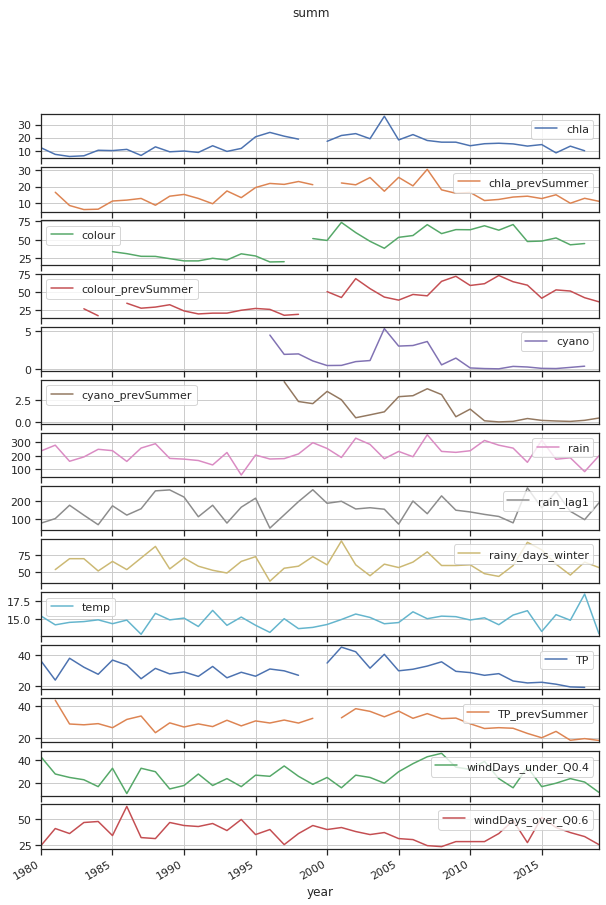

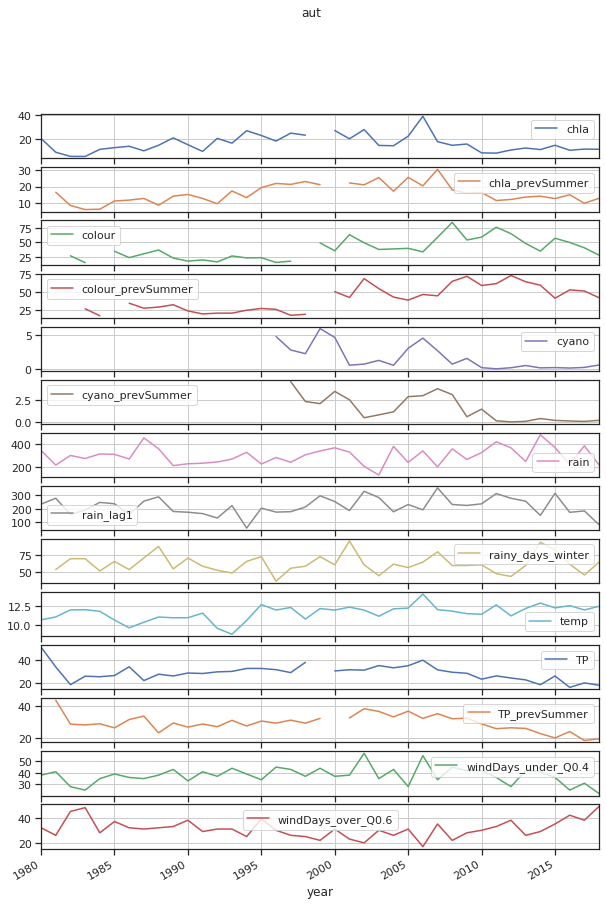

In [26]:
# Split into early summer and late summer and write to csv
for season in ['summ','aut']:
    
    temp_df = df_bn.loc[df_bn['season']==season, :] # Just pick season of interest
    
    # Add year column and reindex using year; drop season column
    temp_df['year'] = temp_df.index.year
    temp_df.set_index('year', inplace=True)
    temp_df.drop('season', axis=1, inplace=True)
    
    # In reality, won't have data for any of the in-lake _lag1 variables, so drop these from the output df
#     if season == 'summ':
    temp_df.drop(['chla_lag1','TP_lag1','colour_lag1','cyano_lag1'], axis=1, inplace=True)
    
    # Write to csv
    temp_df.to_csv(os.path.join(out_file,'VansjøData_%s_forBN.csv' %season))
    
    # Plot time series and save figures
    temp_df.plot(subplots=True, figsize=(10,15), title='%s'%season, grid=True)
    plt.savefig(os.path.join(graph_outfolder,'VansjøData_%s_timeseries.png' %season))


In [27]:
season_df.head()

,Pptn,Temp,Wind_speed,PET,Q,TP_catch,chl-a_lake,TP_lake,colour_lake,PTI,...,Temp_subzero_winterSum,Wind_under_Q0.2_winterSum,Wind_under_Q0.4_winterSum,Wind_over_Q0.6_winterSum,Wind_over_Q0.8_winterSum,TP_lake_prevSummer,colour_lake_prevSummer,chl-a_lake_prevSummer,Temp_prevSummer,CyanoBiovol_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-31,22.125336,-6.757972,2.319355,0.000000,6.095174,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-04-30,79.892563,-1.658246,3.042222,38.550908,28.217376,130.000000,3.971429,45.250000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-07-31,234.732986,15.381829,3.101087,341.791701,30.799440,68.333333,12.169127,36.084127,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-10-31,344.837282,10.630212,3.547826,185.500285,56.804026,113.500000,20.773333,51.061905,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-01-31,140.053816,-1.400335,3.696739,2.283018,38.566541,NaN,NaN,NaN,NaN,NaN,...,101.0,48.0,74.0,70.0,45.0,43.573016,NaN,16.47123,13.00602,NaN


# Split into separate matrices for the 4 possible response variables & look at correlations

First, decide whether want to keep all seasons, or just look at one season

In [28]:
season_slice = 'summ' # one of 'all', 'wint', 'spr','summ','aut'

print(len(season_df))

if season_slice in ['wint', 'spr','summ','aut']:
    season_df = season_df.loc[season_df['Season']==season_slice, :]

print(len(season_df))

159
40


In [29]:
# sorted(season_df.columns)

## Lake TP conc

In [30]:
# First, lake TP concentration is the dependent variable.
cols_to_drop = [
 'Biovolume',
 'Biovolume_lag1',
 'CyanoBiovol',
 'CyanoBiovol_lag1',
 'CyanoBiovol_prevSummer',
 'PTI',
 'PTI_lag1',
 'chl-a_lake',
 'chl-a_lake_lag1',
 'chl-a_lake_prevSummer',
 'colour_lake',
 'colour_lake_lag1',
 'colour_lake_prevSummer',
 'Temp_subzero',
 'TP_lake_lag1'
    ]

season_df_TP = season_df.drop(cols_to_drop,axis=1)
print (len(season_df_TP))

# Drop any rows where TP_lake is a NaN
season_df_TP.dropna(subset=['TP_lake'], inplace=True)
print (len(season_df_TP))
season_df_TP.head()

40
38


,Pptn,Temp,Wind_speed,PET,Q,TP_catch,TP_lake,Rain_day,Pptn_intense,Wind_under_Q0.2,...,Pptn_intense_winterSum,PET_winterSum,Q_winterSum,Temp_subzero_winterSum,Wind_under_Q0.2_winterSum,Wind_under_Q0.4_winterSum,Wind_over_Q0.6_winterSum,Wind_over_Q0.8_winterSum,TP_lake_prevSummer,Temp_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1980-07-31,234.732986,15.381829,3.101087,341.791701,30.799440,68.333333,36.084127,38,6,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-07-31,277.557313,14.131170,3.836957,320.174316,37.862640,NaN,23.583333,35,8,7.0,...,11.0,28.031965,90.698832,101.0,48.0,74.0,70.0,45.0,43.573016,13.006020
1982-07-31,158.725613,14.477725,3.691304,318.228851,18.691344,45.500000,37.777778,25,7,9.0,...,15.0,41.905371,NaN,92.0,55.0,91.0,60.0,36.0,28.833333,12.574081
1983-07-31,190.723657,14.588270,4.078261,320.759861,20.778336,NaN,31.960000,29,5,5.0,...,15.0,56.686881,118.247213,56.0,46.0,72.0,86.0,53.0,28.336806,13.213326
1984-07-31,247.105355,14.832075,4.044565,329.067020,14.499562,128.100000,27.360000,34,9,4.0,...,8.0,43.411276,58.284835,93.0,35.0,61.0,94.0,64.0,29.055000,13.281862


In [31]:
# Take a look at what's missing
# First, drop any columns which don't have NaNs, then plot
# monthly_df_lakeTP.loc[:, monthly_df_lakeTP.isna().any()].plot(subplots=True, figsize=(12,30))

In [32]:
X = season_df_TP.drop(['TP_lake'],axis=1)
y = season_df_TP['TP_lake']
corr_df = X.corrwith(y)
corr_df.sort_values()

Wind_over_Q0.6_winterSum    -0.376410
Wind_over_Q0.8_winterSum    -0.218884
Wind_speed_lag1             -0.173625
Temp_lag1                   -0.152096
Wind_over_Q0.6_lag1         -0.109761
Pptn_intense_lag1           -0.109714
Wind_over_Q0.8_lag1         -0.086542
Rain_day                    -0.077306
Wind_speed                  -0.076270
Wind_over_Q0.6              -0.075945
Temp_prevSummer             -0.069893
Temp                        -0.058663
Q_lag1                      -0.053229
PET_lag1                    -0.023855
Wind_over_Q0.8              -0.023830
TP_catch                    -0.014916
Temp_subzero_winterSum      -0.004667
PET_winterSum                0.031367
Temp_subzero_lag1            0.059901
Pptn_lag1                    0.072773
Q                            0.076966
Rain_day_lag1                0.088578
Wind_under_Q0.4              0.104412
Pptn                         0.119604
Rain_day_winterSum           0.164891
TP_catch_lag1                0.178163
Pptn_intense

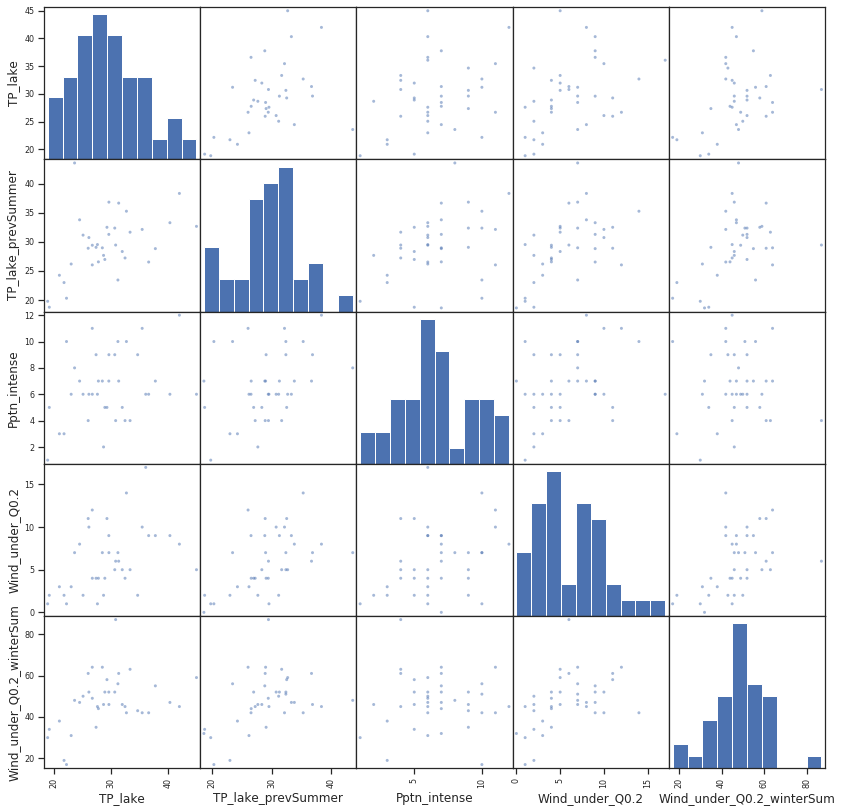

In [33]:
vars_for_scatterplot = ['TP_lake','TP_lake_prevSummer', 'Pptn_intense', 'Wind_under_Q0.2', 'Wind_under_Q0.2_winterSum']

pd.plotting.scatter_matrix(season_df.loc[:,vars_for_scatterplot], figsize=(14,14));

plt.savefig(os.path.join(graph_outfolder,'seasonal_scattermatrix_TP_%s_%s.png'%(season_slice,basin)))

**Van2 (Vanemfjorden), Comments:**

All seasons together:
- As with monthly data, the best potential explanatory variables are lake TP concentration from the previous season, then the previous summer (CCs 0.38, 0.33)
- Possible wind effect too: as with monthly data, the calmer the previous winter, the higher the TP (CCs 0.35 and lower. Highest CC (-0.35) for wind days > Q0.8). No obvious mechanism for this. But also have good correlation between e.g. lake TP the previous summer and the following winter's wind (and early summer wind the next year). So this could be complicated by two variables with trends, hard to know if it's causative.
- Everything else weaker.
- No link to air T seen, unlike Storefjorden. Because it's shallower, so don't get such stratification?
- No relation with met variables relating to delivery. Suggesting internal processing and P sources are more important?

**Just early summer (May-Jul):**
- Super strong correlation with spring TP (CC 0.70). Rest of the CCs all under 0.47
- Lake TP previous summer (CC 0.47)
- Wind vars:
        Current season - wind days under Q0.2 (CC 0.42). i.e. calmer gives higher TP
        Winter wind - wind days over Q0.6 (CC -0.38) or under Q0.2 (CC 0.38), i.e. windier winter gives lower TP/calmer winter gives higher TP
- Vars relating to delivery:
        Number of intense pptn days (CC 0.32). Graph not entirely convincing
        Pptn_winterSum (CC 0.22). Graph shows big blob, apart from highest lake TP also happened to be wettest early summer

**Just late summer (Aug-Oct):**
- TP_lake_prevSummer (0.64)
- Wind vars: similar to early summer. Some strong correlations with wind, winter wind, etc., but not sure how to deal with them.

## Response var = Lake chl-a concentration

In [34]:
# 2) chl-a concentration
cols_to_drop = [
 'Biovolume',
 'Biovolume_lag1',
 'CyanoBiovol',
 'CyanoBiovol_lag1',
 'CyanoBiovol_prevSummer',
 'PTI',
 'PTI_lag1',
 'Temp_subzero'
    ]

season_df_lake_chla = season_df.drop(cols_to_drop,axis=1)
print (len(season_df_lake_chla))

# Drop any rows where explanatory variable value is a NaN
season_df_lake_chla.dropna(subset=['chl-a_lake'], inplace=True)
print (len(season_df_lake_chla))
# monthly_df_lake_chla.head()

40
38


In [35]:
X = season_df_lake_chla.drop(['chl-a_lake'],axis=1)
y = season_df_lake_chla['chl-a_lake']
corr_df = X.corrwith(y)
corr_df.sort_values()

Wind_over_Q0.6_winterSum    -0.533788
Wind_over_Q0.8_winterSum    -0.462657
Wind_over_Q0.8              -0.294273
Wind_over_Q0.6              -0.247771
Wind_speed                  -0.238967
Q_lag1                      -0.194819
Wind_over_Q0.6_lag1         -0.180952
Wind_over_Q0.8_lag1         -0.157308
Wind_speed_lag1             -0.144673
TP_catch_lag1               -0.124986
TP_lake_lag1                -0.120045
Q                           -0.075317
Rain_day_winterSum          -0.048452
Temp_subzero_lag1           -0.046183
Temp                        -0.045211
Temp_subzero_winterSum      -0.044722
Pptn_intense_winterSum      -0.036562
Q_winterSum                 -0.028148
Pptn_winterSum              -0.027542
Rain_day_lag1               -0.022095
Pptn_lag1                   -0.008319
colour_lake_lag1             0.053653
PET_winterSum                0.055232
TP_catch                     0.055876
Pptn_intense_lag1            0.059928
PET_lag1                     0.063972
Wind_under_Q

**Comments on chl-a correlations for Van 2:**

**Just early summer (May-July):**
Strongest correlations:
- Spring chl-a (CC 0.73)
- Mean Chl-a the previous growing season (May-Oct) (0.59)
- Lake TP conc (0.42). The first time a positive link between lake biol and TP has come out!
- Winter wind (wind_over_Q0.6 have CC of -0.53!), but not convinced by this (see comments under TP section. Here, have a better correlation between winter wind and chl-a the previous summer than early summer's chl-a...). So exclude for now.
- Rain days: In first version of anlysis, had sum of winter rain days (0.53) & sum of rain days in spring (0.50). But have now re-defined a rain day as having pptn > 0.2mm or 1 mm, and this relationship has totally gone! Drat! Though looking more closely, even in the original data  there was pretty much no correlation between chl-a and winter pptn sum or intense rain days, so always shaky. There goes the climate link though...!!

Rest of CCs all under 0.4

**Late summer (Aug-Oct):**
Strongest correlations are with:
- Lake TP conc (0.59)
- Calm wind: seasonal average (-0.56), over Q0.6 (-0.55), under Q0.4 (CC 0.53)
- Previous growing season mean Chla-lake (0.53)

**Spring chl-a (Feb-Apr):**
Look at this because it's such a strong predictor of early summer chl-a. What is it correlated with? N.B. only 14 years have April data.
- Lake colour (0.6). Higher colour, higher spring chl-a (i.e. not a light limitation thing)
- TP lake (-0.43), i.e. higher lake TP conc, the lower the chl-a. Opposite to CC found in early summer
Think I'll discard this.


**Temperature effect very weak when looking at one season at a time!! Wind and nutrients appear more important**



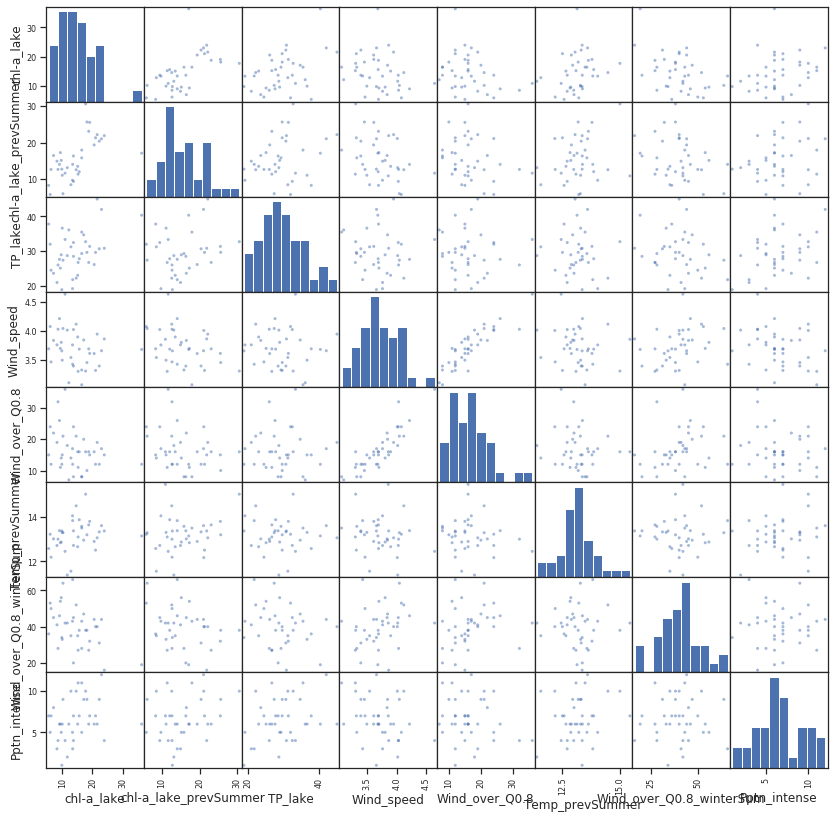

In [36]:
vars_for_scatterplot = ['chl-a_lake','chl-a_lake_prevSummer', 'TP_lake','Wind_speed','Wind_over_Q0.8',
                        'Temp_prevSummer','Wind_over_Q0.8_winterSum', 'Pptn_intense']

pd.plotting.scatter_matrix(season_df.loc[:,vars_for_scatterplot], figsize=(14,14));

# plt.savefig(os.path.join(graph_outfolder,'seasonal_scattermatrix_chl-a_%s_%s.png'%(season_slice,basin)))

Previously, Jannicke Moe found an interaction between wind and temperature - with cyanobacteria blooms only when it was calm and warm. I think this was when she included within-year variability (which we're not doing here), but I will double-check for a temperature-wind interactive effect in between-year variability too. First just do this graphically by splitting the temperature into 'high' and 'low', and plotting chl-a vs wind, grouped by temperature class. Jannicke split the water temp into above and below 19 degrees C

In [37]:
# # Regression tree to decide whether there's any reason for a temperature split

# # For early summer:
# # reg_df = season_df_lake_chla[['Temp', 'Wind_over_Q0.6_winterSum','chl-a_lake']].dropna()
# # feature_cols = ['Temp', 'Wind_over_Q0.6_winterSum']

# # For late summer (autumn):
# reg_df = season_df_lake_chla[['Temp', 'chl-a_lake']].dropna()
# feature_cols = ['Temp']

# X = reg_df[feature_cols] # Features
# y = reg_df['chl-a_lake'] # Target variable

# # create a regressor object 
# regressor = DecisionTreeRegressor(random_state = 0)  
  
# # fit the regressor with X and Y data 
# regressor.fit(X, y) 

# y_pred = regressor.predict(X) 

# # Model Accuracy, how often is the classifier correct?
# # print("Accuracy:",metrics.accuracy_score(y, y_pred))

# # export the decision tree to a tree.dot file for visualizing the plot easily anywhere
# # Note: this produces a .dot file, which can either be converted to a png using pydotplus (not installed on the hub at the mo),
# # or visualized using http://www.webgraphviz.com/ by copying the data from the ‘tree.dot’ file.

# from sklearn.tree import export_graphviz

# export_graphviz(regressor, out_file ='tree.dot', 
#                feature_names =feature_cols)  

From this, pick air temp threshold of 13.5 degrees for early summer, and split into high or low

In [38]:
# def disc_temp(temp):
#     if temp > 11.0: return 'warm' #13.5 for early summer, 11 for late summer
#     else: return 'cold'
# season_df_lake_chla['Temp_2cat'] = season_df_lake_chla['Temp'].map(disc_temp)
# season_df_lake_chla[['Temp','Temp_2cat']].head()

# # Scatter plot again, but grouping by whether warm or cold
# g = sns.pairplot(season_df_lake_chla.loc[:,vars_for_scatterplot+['Temp_2cat']], hue="Temp_2cat");
# plt.savefig(os.path.join(graph_outfolder,'seasonal_scattermatrix_chl-a_%s_byTemp_%s.png'%(season_slice,basin)))

## Response var = max cyanobacterial biovolume

In [39]:
# cols to drop:
cols_to_drop = [
 'Biovolume',
 'Biovolume_lag1',
 'PTI',
 'PTI_lag1',
 'Temp_subzero'
    ]

season_df_cyano = season_df.drop(cols_to_drop,axis=1)
print (len(season_df_cyano))

# Drop any rows where explanatory var value is a NaN
season_df_cyano.dropna(subset=['CyanoBiovol'], inplace=True)
print (len(season_df_cyano))

40
23


In [40]:
X = season_df_cyano.drop(['CyanoBiovol'],axis=1)
y = season_df_cyano['CyanoBiovol']
corr_df = X.corrwith(y)
corr_df.sort_values()

Wind_over_Q0.6_winterSum    -0.578317
Q_lag1                      -0.512508
colour_lake_lag1            -0.512045
Wind_over_Q0.8_winterSum    -0.509887
colour_lake_prevSummer      -0.499327
colour_lake                 -0.392719
Wind_speed_lag1             -0.350840
Pptn_intense_winterSum      -0.335554
Wind_over_Q0.6_lag1         -0.307299
Pptn_intense_lag1           -0.300387
Wind_over_Q0.8_lag1         -0.299473
Pptn_lag1                   -0.298270
Q_winterSum                 -0.273834
Temp                        -0.273264
Pptn_winterSum              -0.238326
Rain_day_lag1               -0.219842
PET_winterSum               -0.211908
Temp_lag1                   -0.199524
Wind_over_Q0.8              -0.190611
Wind_over_Q0.6              -0.177785
Rain_day_winterSum          -0.143873
Wind_speed                  -0.128888
Pptn                        -0.093416
Rain_day                    -0.073126
TP_catch_lag1               -0.058215
PET_lag1                    -0.057980
Q           

**Correlations in Van 2:**

**Just early summer (May-July):**
Strongest CCs:
- chl-a_lake (0.77)
- Previous growing season: chl-a (0.58), TP (0.51), cyano average (0.47) or max (0.39).
- Lake colour: prevSummer (-0.50), current season (-0.4), spring (-0.51) (all 3 very correlated with one another)
- Previous season's discharge (-0.51), higher Q correlated with lower cyano... Not apparent in first version of analysis, where I didn't discard seasons with missing data.
- Wind under Q0.2 in current season (0.42), and in winter (0.40). Windy winter (>Q0.6; -0.58!), but again, misgivings about this.

For first time have TP and wind coming in a way we might expect. Scatter plots: only chl-a and previous summer's cyano are convincing.

**Just late summer (Aug-Oct):**
Strongest CCs:
- chl-a_lake (0.74), Lake TP conc (0.62)
- Prev growing season mean cyanobiovol (0.67), stronger than early summer (CC 0.48)
- Lake colour, previous summer (-0.50), current season (-0.45)
- Wind: mean wind speed (-0.41)

**All seasons together (not updated with new met data or 2018-19 data):**
Similar to monthly:
- Strong correlation with lake chl-a (CC 0.73)
- Strong correlation with previous season's cyano biovol (CC 0.59), weaker with previous summer's average cyanobiovol
- Strong colour effect: current and previous season's colour (-0.65, -0.58), and previous summer's (-0.55). These 3 are all correlated with one another. BUT, **correlation or causation**? Over the study period, colour went up and cyanobacteria went down, but perhaps because of entirely independently. **If light limitation were an issue, wouldn't we expect a relationship between colour and chl-a too?**

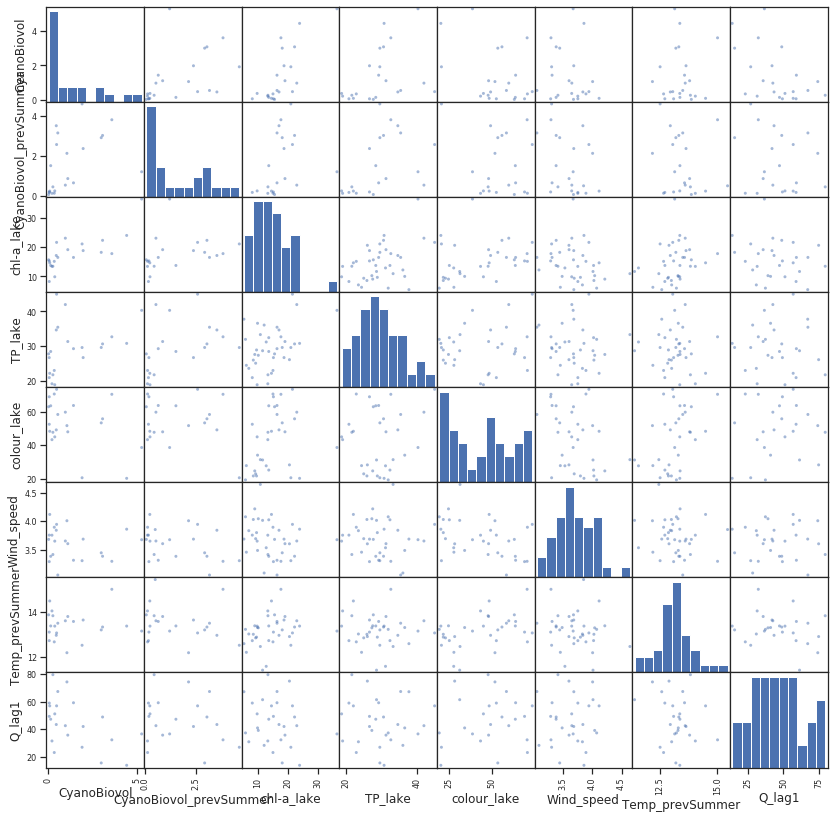

In [41]:
vars_for_scatterplot = ['CyanoBiovol','CyanoBiovol_prevSummer','chl-a_lake','TP_lake','colour_lake',
                        'Wind_speed','Temp_prevSummer','Q_lag1']

pd.plotting.scatter_matrix(season_df.loc[:,vars_for_scatterplot], figsize=(14,14));

plt.savefig(os.path.join(graph_outfolder,'seasonal_scattermatrix_cyano_%s_%s.png'%(season_slice,basin)))

As with chl-a, look for any interactions with temperature by splitting into low and high temperature groups

In [34]:
# # Regression tree to decide whether there's any reason for a temperature split

# # For early summer:
# # reg_df = season_df_lake_chla[['Temp', 'Wind_over_Q0.6_winterSum','chl-a_lake']].dropna()
# # feature_cols = ['Temp', 'Wind_over_Q0.6_winterSum']

# # For late summer (autumn):
# reg_df = season_df_cyano[['Temp', 'CyanoBiovol']].dropna()
# feature_cols = ['Temp']

# X = reg_df[feature_cols] # Features
# y = reg_df['CyanoBiovol'] # Target variable

# # create a regressor object 
# regressor = DecisionTreeRegressor(random_state = 0)  
  
# # fit the regressor with X and Y data 
# regressor.fit(X, y) 

# y_pred = regressor.predict(X) 

# # Model Accuracy, how often is the classifier correct?
# # print("Accuracy:",metrics.accuracy_score(y, y_pred))

# # export the decision tree to a tree.dot file for visualizing the plot easily anywhere
# # Note: this produces a .dot file, which can either be converted to a png using pydotplus (not installed on the hub at the mo),
# # or visualized using http://www.webgraphviz.com/ by copying the data from the ‘tree.dot’ file.

# from sklearn.tree import export_graphviz

# export_graphviz(regressor, out_file ='tree.dot', 
#                feature_names =feature_cols)  

From this, pick air temp threshold of 14 degrees for early summer, 11 in late summer, to split into high or low

In [35]:
# def disc_temp(temp):
#     if temp > 14.0: return 'warm'
#     else: return 'cold'
# season_df_cyano['Temp_2cat'] = season_df_cyano['Temp'].map(disc_temp)
# season_df_cyano[['Temp','Temp_2cat']].head()

# # Scatter plot again, but grouping by whether warm or cold
# g = sns.pairplot(season_df_cyano.loc[:,vars_for_scatterplot+['Temp_2cat']], hue="Temp_2cat");
# plt.savefig(os.path.join(graph_outfolder,'seasonal_scattermatrix_cyano_%s_byTemp_%s.png'%(season_slice,basin)))

## Response var = Lake colour

In [36]:
# Drop all ecological-related stuff

cols_to_drop = [
 'Biovolume',
 'Biovolume_lag1',
 'CyanoBiovol',
 'CyanoBiovol_lag1',
 'CyanoBiovol_prevSummer',
 'PTI',
 'PTI_lag1',
 'Season',
 'TP_catch',
 'TP_catch_lag1',
 'TP_lake',
 'TP_lake_lag1',
 'TP_lake_prevSummer',
 'chl-a_lake',
 'chl-a_lake_lag1',
 'chl-a_lake_prevSummer',
 'Temp_subzero'
    ]

season_df_lakeColour = season_df.drop(cols_to_drop,axis=1)
print (len(season_df_lakeColour))

# Drop any rows where response var is a NaN
season_df_lakeColour.dropna(subset=['colour_lake'], inplace=True)
print (len(season_df_lakeColour))
season_df_lakeColour.head()

155
99


,Pptn,Temp,Wind_speed,PET,Q,colour_lake,Rain_day,Pptn_intense,Wind_under_Q0.2,Wind_under_Q0.4,...,Rain_day_winterSum,Pptn_intense_winterSum,PET_winterSum,Q_winterSum,Temp_subzero_winterSum,Wind_under_Q0.2_winterSum,Wind_under_Q0.4_winterSum,Wind_over_Q0.6_winterSum,Wind_over_Q0.8_winterSum,colour_lake_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1982-10-31,297.668159,10.870945,3.890217,204.064938,20262268.8,26.666667,77,16,11.0,28.0,...,105.0,14.0,50.619540,96553900.8,106.0,47.0,81.0,72.0,42.0,NaN
1983-04-30,122.882007,-0.047116,3.348315,46.470708,37266912.0,34.000000,47,3,20.0,36.0,...,121.0,18.0,62.161543,124071782.4,71.0,43.0,72.0,86.0,48.0,26.666667
1983-07-31,182.728817,13.517998,4.078261,320.759861,20778336.0,19.400000,63,7,5.0,23.0,...,121.0,18.0,62.161543,124071782.4,71.0,43.0,72.0,86.0,48.0,26.666667
1983-10-31,275.606690,10.877162,4.440217,202.271896,27490838.4,14.666667,57,13,8.0,25.0,...,121.0,18.0,62.161543,124071782.4,71.0,43.0,72.0,86.0,48.0,26.666667
1984-04-30,74.093285,-0.587583,3.718889,40.967914,39079065.6,28.000000,55,2,20.0,36.0,...,121.0,5.0,47.655810,73802188.8,107.0,36.0,65.0,94.0,58.0,17.033333


In [37]:
X = season_df_lakeColour.drop(['colour_lake'],axis=1)
y = season_df_lakeColour['colour_lake']
corr_df = X.corrwith(y)
corr_df.sort_values()

Temp                        -0.448365
PET                         -0.425872
Wind_over_Q0.6_lag1         -0.413877
Wind_speed_lag1             -0.400680
Wind_over_Q0.6              -0.272402
Wind_over_Q0.6_winterSum    -0.251519
Wind_speed                  -0.244770
PET_lag1                    -0.239275
Wind_over_Q0.8_winterSum    -0.214616
Wind_over_Q0.8_lag1         -0.205944
Temp_lag1                   -0.158958
Temp_subzero_winterSum      -0.124755
Wind_under_Q0.2_winterSum   -0.115827
Wind_over_Q0.8              -0.098510
Pptn                         0.064790
Pptn_intense                 0.071277
Temp_subzero_lag1            0.161435
Wind_under_Q0.4_winterSum    0.176624
Rain_day                     0.181658
Pptn_intense_winterSum       0.218342
Pptn_winterSum               0.220969
Wind_under_Q0.2              0.259770
Wind_under_Q0.4              0.260148
PET_winterSum                0.288979
Q_winterSum                  0.308056
Rain_day_winterSum           0.344136
Q_lag1      

**Lake colour correlations in Van 2, comments:**

**All seasons:**
- Strong auto-correlation with lake colour the previous summer (0.77) and season (0.76)
- Delivery: Discharge sum current season (0.61), previous season (0.54) and during winter (0.53). Then rain-related features in previous season (CCs 0.53-0.48).
- Temperature and PET: -0.45, -0.43. i.e. warmer is lower colour. Just seasonal effect.

**Just early summer (May-July):**
Key things:
- Lake colour previous summer (0.85) and spring (0.87)
- Pptn (0.54)

**Late summer (Aug-Oct):**
- colour in early summer (0.87) and the previous summer (0.79)
- Rain things: Early summer precipitation (0.61) and intense precipitation (0.53)
- Current season's discharge (0.46)
All rest of CCs under 0.45



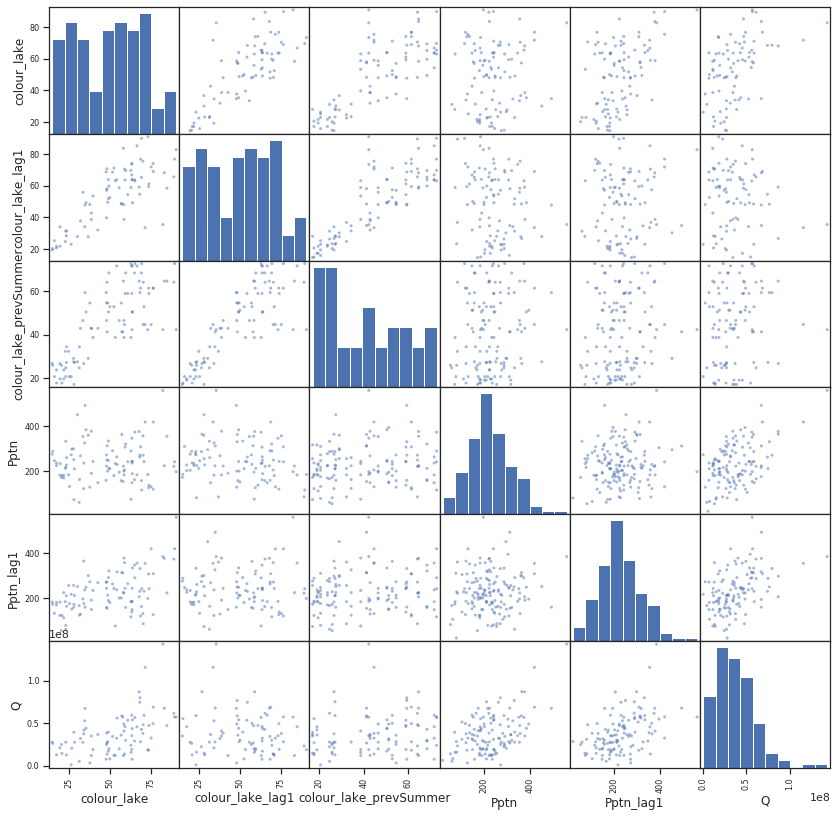

In [38]:
vars_for_scatterplot = ['colour_lake', 'colour_lake_lag1','colour_lake_prevSummer', 'Pptn',
                        'Pptn_lag1', 'Q']

pd.plotting.scatter_matrix(season_df.loc[:,vars_for_scatterplot], figsize=(14,14));

plt.savefig(os.path.join(graph_outfolder,'seasonal_scattermatrix_colour_%s_%s.png'%(season_slice,basin)))

## Write output csvs split by variable

In [89]:
# Save for the 'all' seasons slice, slicing then done in the feature selection (or other) notebooks

season_df_TP.to_csv(os.path.join(out_file,'dataMatrix_seasonal_TP_%s.csv'%basin), index_label='Date')
season_df_lake_chla.to_csv(os.path.join(out_file,'dataMatrix_seasonal_Chl-a_%s.csv'%basin), index_label='Date')
season_df_cyano.to_csv(os.path.join(out_file,'dataMatrix_seasonal_CyanoBiovol_%s.csv'%basin), index_label='Date')
season_df_lakeColour.to_csv(os.path.join(out_file,'dataMatrix_seasonal_colour_lake_%s.csv'%basin), index_label='Date')